<a href="https://colab.research.google.com/github/cryptowhaler/Sigh_Finance/blob/master/tree/master/Harvests/Interest_Yields.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SIMULATEDINTEREST RATE MODELS FOR  :** 
1. COMPOUND FINANCE
2. AAVE
3. SIGH FINANCE 


In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# GLOBAL VARIABLES

BLOCKS_PER_YEAR = 6669

**VARIABLES FOR EACH INTEREST RATE MODEL**

In [3]:
# COMPOUND FINANCE

Compound_RESERVE_FACTOR = 0.1 # percent of interest paid by borrowers reserved by the protocol (same for both IRMs)

Compound_JUMP_IRM_BASE_BORROW_RATE = 0 # Annualized Borrow Rate : 0 % Utilization
Compound_JUMP_IRM_BORROW_RATE_MULTIPLIER = 0.05 # Annualized Borrow Rate : 100 % Utilization - kink
Compound_JUMP_IRM_KINK_UTILIZATION_RATE = 0.8 # utilization rate at which slope of borrow rate increases
Compound_JUMP_IRM_KINK_BORROW_RATE_MULTIPLIER = 1 # additional borrow rate multiplier after the kink

In [4]:
#AAVE 



In [5]:
#SIGH FINANCE [ IN DEVELOPMENT / SIMULATION PHASE ]
# we use the "kink" from the jump IRM in the PID controller too, this allows the model to instantly respond
# to borrow saturation. This also serves as the "P" in the PID controller

SIGH_RESERVE_FACTOR = 0.1 # percent of interest paid by borrowers reserved by the protocol (same for both IRMs)

SIGH_PID_IRM_TARGET_UTILIZATION_RATE = 0.8 # what utilization rate the PID controller is trying to achieve
SIGH_PID_IRM_KINK_UTILIZATION_RATE = 0
SIGH_PID_IRM_KINK_BORROW_RATE_MULTIPLIER = 0.1
SIGH_PID_IRM_INTEGRAL_GAIN = 0.02 # how quickly the PID IRM will decrease borrow interest rates when utilization rate is below target and vice versa
SIGH_PID_IRM_DERIVATIVE_GAIN = 100 # how aggressively the PID IRM inversely corrects interest rates to avoid overshooting

**GETTERS**

In [14]:
# GETTER FUNCTIONS FOR "COMPOUND FINANCE"

# BORROWING INTEREST RATES 
def get_COMPOUND_borrow_interest_rate_jump_irm():
  utilization_rate = get_utilization_rate()

  if utilization_rate == 0:
    return 0

  normal_borrow_rate = utilization_rate * Compound_JUMP_IRM_BORROW_RATE_MULTIPLIER + Compound_JUMP_IRM_BASE_BORROW_RATE

  if utilization_rate < Compound_JUMP_IRM_KINK_UTILIZATION_RATE:
    return normal_borrow_rate
  else:
    excess_utilization = utilization_rate - Compound_JUMP_IRM_KINK_UTILIZATION_RATE
    return normal_borrow_rate + (excess_utilization * Compound_JUMP_IRM_KINK_BORROW_RATE_MULTIPLIER)

# SUPPLIERS INTEREST RATES 
def get_COMPOUND_supply_interest_rate_jump_irm():
  if borrowed_currency == 0:
    return 0.05 # "unstick model at simulation start"
  
  return get_COMPOUND_borrow_interest_rate_jump_irm() * (1 - Compound_RESERVE_FACTOR) * get_utilization_rate()



In [7]:
# GETTER FUNCTIONS FOR "SIGH FINANCE [ IN DEVELOPMENT / SIMULATION PHASE ]"

# PROPORTIONAL SIGNAL PID-IRM
def get_SIGH_proportional_signal_pid_irm():
  utilization_rate = get_utilization_rate()
  proportional_signal = 0

  if utilization_rate > SIGH_PID_IRM_KINK_UTILIZATION_RATE:
    excess_utilization = utilization_rate - SIGH_PID_IRM_KINK_UTILIZATION_RATE
    proportional_signal = excess_utilization * SIGH_PID_IRM_KINK_BORROW_RATE_MULTIPLIER

  return proportional_signal

# BORROWING INTEREST RATES 
def get_SIGH_borrow_interest_rate_pid_irm():
  global pid_derivative_signal, pid_integral_accumulator, pid_last_evaluated_block, pid_last_evaluated_utilization_rate, block_number

  utilization_rate = get_utilization_rate()

  if utilization_rate == 0:
    return 0

  proportional_signal = get_proportional_signal_pid_irm()

  pid_integral_accumulator += (utilization_rate - SIGH_PID_IRM_TARGET_UTILIZATION_RATE) / SIGH_BLOCKS_PER_YEAR
  integral_signal = pid_integral_accumulator * SIGH_PID_IRM_INTEGRAL_GAIN

  if pid_last_evaluated_block != block_number:
    block_difference = block_number - pid_last_evaluated_block
    pid_derivative_signal = (utilization_rate - pid_last_evaluated_utilization_rate) / (SIGH_BLOCKS_PER_YEAR / block_difference) * SIGH_PID_IRM_DERIVATIVE_GAIN

  pid_last_evaluated_block = block_number
  pid_last_evaluated_utilization_rate = utilization_rate

  return max(0, proportional_signal + integral_signal + pid_derivative_signal)

# SUPPLIERS INTEREST RATES 
def get_SIGH_supply_interest_rate_pid_irm():
  if borrowed_currency == 0:
    return 0.05 # "unstick model at simulation start"
  
  return get_SIGH_borrow_interest_rate_pid_irm() * (1 - SIGH_RESERVE_FACTOR) * get_utilization_rate()



GETTERS COMMON FOR BOTH IRMs

In [8]:
# GETS UTILIZATION RATE
def get_utilization_rate():
  if lent_currency == 0:
    return 0

  return borrowed_currency / lent_currency

# CURRENT AVAILABLE LIQUIDITY
def get_liquidity():
  return lent_currency - borrowed_currency

# GET BORROWER INTEREST RATES 
def get_borrow_interest_rate():
  if interest_rate_model_in_use == 'compound':
    return get_COMPOUND_borrow_interest_rate_jump_irm()
  if interest_rate_model_in_use == 'sigh':
    return get_SIGH_borrow_interest_rate_pid_irm()

# GET SUPPLIER INTEREST RATES 
def get_supply_interest_rate():
  if interest_rate_model_in_use == 'compound':
    return get_COMPOUND_supply_interest_rate_jump_irm()
  if interest_rate_model_in_use == 'sigh':
    return get_SIGH_supply_interest_rate_pid_irm()

**STATE FOR THE INTEREST RATE MODELS**

In [9]:
interest_rate_model_in_use = 'compound'

block_number = 0

lent_currency = 0
borrowed_currency = 0

pid_derivative_signal = 0
pid_integral_accumulator = 0
pid_last_evaluated_block = 0
pid_last_evaluated_utilization_rate = 0

# **SIMULATED AGENTS**
1. **Commercial Trader Agent :** 



*   The purpose of this agent is to simulate a trader who has an opinion on the fair market interest rate to lend or borrow, and will open positions when the market-offered interest rate is favourable to them.
*   The agent's equilibrium rate (their "opinion" on what the fair market interest rate should be) is given by a normal random walk with a drift towards the market-offered borrow rate at each timestep. This ensures there is a dispersion of opinions around some volatile consensus interest rate.
*   Each agent's bankroll (total borrowing or lending power) is drawn from a PARETO Distribution. The % of their bankroll which they borrow or lend is based on ***tanh*** biased. by their internal equilibrium rate

In [10]:
# CLASS : DEFINES A COMMERCIAL TRADING AGENT

# CONSTANTS
NUM_COMMERCIAL_TRADERS = 100 # the number of commercial traders in the simulation
COMMERCIAL_TRADER_INITIAL_EQUILIBRIUM_RATE = 0.05 # what each commercial trader's equilibrium rate starts at
COMMERCIAL_TRADER_PARETO_SHAPE = 3 # higher = more fat-tailed
COMMERCIAL_TRADER_MODE_BANKROLL = 10_000 # the mode bankroll of a commercial trader, from a Pareto distribution
COMMERCIAL_TRADER_INTERNAL_VOLATILITY = 100 # annualized volatility of the equilibrium rate
COMMERCIAL_TRADER_REGULARIZATION_RATE = 0.9 # how much their equlibrium rate "decays" to the market-offered borrow rate per year
COMMERCIAL_TRADER_RISK_AVERSION = 25 # scaling factor of the tanh (trader requires a larger buffer in their favor to take a position)

class CommercialTrader:

  def __init__(self):
    self.bankroll = (np.random.pareto(COMMERCIAL_TRADER_PARETO_SHAPE)) * COMMERCIAL_TRADER_MODE_BANKROLL
    self.equilibrium_rate = COMMERCIAL_TRADER_INITIAL_EQUILIBRIUM_RATE
    self.position = 0 # positive means supplying, negative means borrowing

  def _get_target_position(self):
    borrow_interest_rate = get_borrow_interest_rate()
    supply_interest_rate = get_supply_interest_rate()

    borrow_advantage = self.equilibrium_rate - borrow_interest_rate
    supply_advantage = supply_interest_rate - self.equilibrium_rate

    if borrow_advantage >= supply_advantage and borrow_advantage > 0:
      return self.bankroll * math.tanh((borrow_interest_rate - self.equilibrium_rate) * COMMERCIAL_TRADER_RISK_AVERSION)
    elif supply_advantage >= borrow_advantage and supply_advantage > 0:
      return self.bankroll * math.tanh((supply_interest_rate - self.equilibrium_rate) * COMMERCIAL_TRADER_RISK_AVERSION)
    else:
      return 0

  # AGENT SUPPLIES LIQUIDITY (DEPOSIT)
  def _supply(self, supply_amount):
    global lent_currency

    self.position += supply_amount
    lent_currency += supply_amount

  # AGENT WITHDRAWS LIQUIDITY (REDEEM)
  def _withdraw(self, withdrawal_amount):
    global lent_currency

    actual_withdrawal_amount = min(withdrawal_amount, get_liquidity())
    self.position -= actual_withdrawal_amount
    lent_currency -= actual_withdrawal_amount

    return actual_withdrawal_amount == withdrawal_amount

  # AGENT TAKES A LOAN (BORROW)
  def _borrow(self, borrow_amount):
    global borrowed_currency

    actual_borrow_amount = min(borrow_amount, get_liquidity())
    self.position -= actual_borrow_amount
    borrowed_currency += actual_borrow_amount

    return actual_borrow_amount == borrow_amount

  # AGENT REPAYS THE LOAN (REPAY)
  def _repay(self, repay_amount):
    global borrowed_currency

    self.position += repay_amount
    borrowed_currency -= repay_amount

  #SIMMLATES TRADING BEHAVIOUR : AGENT TRIES TO ACHIEVE ITS TARGET POSITION
  def step(self):
    equilibrium_rate_displacement = np.random.normal(scale=COMMERCIAL_TRADER_INTERNAL_VOLATILITY) / BLOCKS_PER_YEAR
    self.equilibrium_rate *= (1 + equilibrium_rate_displacement)
    self.equilibrium_rate -= (self.equilibrium_rate - get_borrow_interest_rate()) * COMMERCIAL_TRADER_REGULARIZATION_RATE / BLOCKS_PER_YEAR

    target_position = self._get_target_position()

    if self.position >= 0 and target_position >= 0:
      position_difference = target_position - self.position
      if position_difference > 0:
        self._supply(position_difference)
      else:
        self._withdraw(-position_difference)
    elif self.position < 0 and target_position < 0:
      position_difference = target_position - self.position
      if position_difference < 0:
        self._borrow(-position_difference)
      else:
        self._repay(position_difference)
    elif self.position >= 0 and target_position < 0:
      if self._withdraw(self.position):
        self._borrow(-target_position)
    elif self.position < 0 and target_position >= 0:
      if self._repay(-self.position):
        self._supply(target_position)

2. **NOISE TRADING AGENT :**

*   This agent is meant to simulate a less-informed trader, or a large trader who is trying to get in and out of positions quickly without slippage.
*   Like the commercial trader, this trader's bankroll is sampled from a PARETO distribution.  
*   Each time-step, the agent has a chance to sample a new target position from a uniform distribution between -1 and 1 times its bankroll. 

In [11]:
# CLASS : DEFINES A NOISE TRADING AGENT

# CONSTANTS
NUM_NOISE_TRADERS = 50 # the number of noise traders in the simulation
NOISE_TRADER_PARETO_SHAPE = 3 # higher = more fat-tailed
NOISE_TRADER_MODE_BANKROLL = 25_000 # the mode bankroll of a noise trader, from a Pareto distribution
NOISE_TRADER_RESAMPLING_RATE = 4 # average number of times per year a noise trader changes their position

class NoiseTrader:
  def __init__(self):
    self.bankroll = np.random.pareto(NOISE_TRADER_PARETO_SHAPE) * NOISE_TRADER_MODE_BANKROLL
    self.position = 0 # positive means supplying, negative means borrowing
    self.target_position = 0

  # AGENT SUPPLIES LIQUIDITY (DEPOSIT)
  def _supply(self, supply_amount):
    global lent_currency

    self.position += supply_amount
    lent_currency += supply_amount

  # AGENT WITHDRAWS LIQUIDITY (REDEEM)
  def _withdraw(self, withdrawal_amount):
    global lent_currency

    actual_withdrawal_amount = min(withdrawal_amount, get_liquidity())
    self.position -= actual_withdrawal_amount
    lent_currency -= actual_withdrawal_amount

    return actual_withdrawal_amount == withdrawal_amount

  # AGENT TAKES A LOAN (BORROW)
  def _borrow(self, borrow_amount):
    global borrowed_currency

    actual_borrow_amount = min(borrow_amount, get_liquidity())
    self.position -= actual_borrow_amount
    borrowed_currency += actual_borrow_amount

    return actual_borrow_amount == borrow_amount

  # AGENT REPAYS THE LOAN (REPAY)
  def _repay(self, repay_amount):
    global borrowed_currency

    self.position += repay_amount
    borrowed_currency -= repay_amount

  #SIMLATES TRADING BEHAVIOUR : AGENT TIRES TO ACHIEVE ITS TARGET POSITION BASED ON RESAMPLING RATE
  def step(self):
    chance_to_resample = NOISE_TRADER_RESAMPLING_RATE / BLOCKS_PER_YEAR
    if random.random() < chance_to_resample:
      self.target_position = self.bankroll * np.random.uniform(low=-1.0, high=1.0)

    target_position = self.target_position

    if self.position >= 0 and target_position >= 0:
      position_difference = target_position - self.position
      if position_difference > 0:
        self._supply(position_difference)
      else:
        self._withdraw(-position_difference)
    elif self.position < 0 and target_position < 0:
      position_difference = target_position - self.position
      if position_difference < 0:
        self._borrow(-position_difference)
      else:
        self._repay(position_difference)
    elif self.position >= 0 and target_position < 0:
      if self._withdraw(self.position):
        self._borrow(-target_position)
    elif self.position < 0 and target_position >= 0:
      if self._repay(-self.position):
        self._supply(target_position)

**INITIALIZING AGENTS AND RUNNING SIMULATIONS FOR COMPOUND FINANCE**

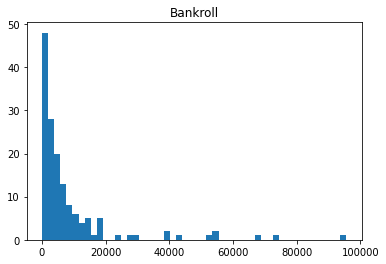

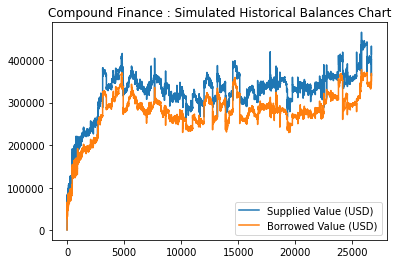

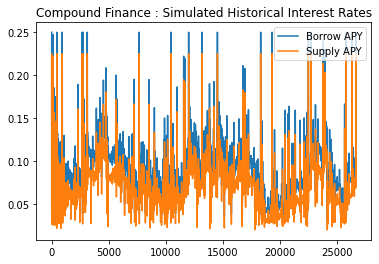

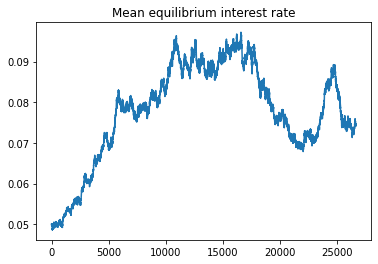

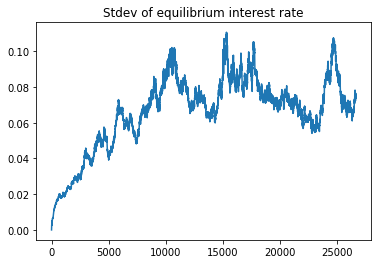

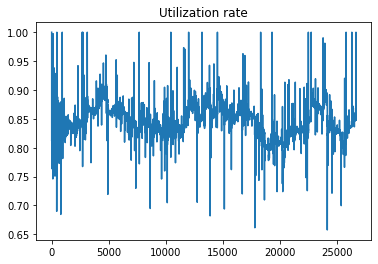

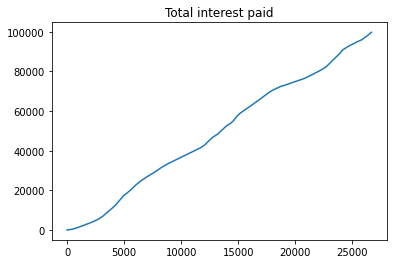

In [15]:
SIMULATION_LENGTH_YEARS = 4

agents = []

#INITIALIZING COMMERCIAL TRADERS
for i in range(NUM_COMMERCIAL_TRADERS):
  agents.append(CommercialTrader())

#INITIALIZING NOISE TRADERS
for i in range(NUM_NOISE_TRADERS):
  agents.append(NoiseTrader())

#PLOTTING INITIAL BALANCE FOR AGENTS
plt.hist([agent.bankroll for agent in agents], bins=50)
plt.title('Bankroll')
plt.show()

# VARIABLES WHICH STORE HISTORICAL LIQUIDITY / BORROWING BALANCES AND INTEREST RATES
lent_currency_history = []
borrowed_currency_history = []
borrow_interest_rate_history = []
supply_interest_rate_history = []
mean_equilibrium_interest_rate_history = []
stdev_equilibrium_interest_rate_history = []
utilization_rate_history = []
interest_paid_history = []

# SIMULATING THE BEHAVIOUR : PER BLOCK BASIS
# 1. We store the current value of State Variables
# 2. Loop over the agents, siulating their behaviour 
for i in range(int(BLOCKS_PER_YEAR * SIMULATION_LENGTH_YEARS)):
  lent_currency_history.append(lent_currency)
  borrowed_currency_history.append(borrowed_currency)
  borrow_interest_rate_history.append(get_borrow_interest_rate())
  supply_interest_rate_history.append(get_supply_interest_rate())
  mean_equilibrium_interest_rate_history.append(np.mean([agent.equilibrium_rate for agent in agents if hasattr(agent, 'equilibrium_rate')]))
  stdev_equilibrium_interest_rate_history.append(np.std([agent.equilibrium_rate for agent in agents if hasattr(agent, 'equilibrium_rate')]))
  utilization_rate_history.append(get_utilization_rate())
  interest_paid_history.append(borrowed_currency * get_borrow_interest_rate() / BLOCKS_PER_YEAR)

  for agent in agents:
    agent.step()


#PLOTTING HISTROICAL CHART OF SUPPLIED / BORROWED BALANCES 
plt.plot(lent_currency_history, label='Supplied Value (USD)')
plt.plot(borrowed_currency_history, label='Borrowed Value (USD)')
plt.title('Compound Finance : Simulated Historical Balances Chart')
plt.legend()
plt.show()

#PLOTTING HISTROICAL INTEREST RATES : SUPPLY APY / BORROW APY 
plt.plot(borrow_interest_rate_history, label='Borrow APY')
plt.plot(supply_interest_rate_history, label='Supply APY')
plt.title('Compound Finance : Simulated Historical Interest Rates')
plt.legend()
plt.show()

#PLOTTING MEAN EQUILIBRIUM INTEREST RATES FOR TRADERS 
plt.plot(mean_equilibrium_interest_rate_history)
plt.title('Mean equilibrium interest rate')
plt.show()

#PLOTTING STD DEV EQUILIBRIUM INTEREST RATES FOR TRADERS 
plt.plot(stdev_equilibrium_interest_rate_history)
plt.title('Stdev of equilibrium interest rate')
plt.show()

#PLOTTING HISTORICAL UTILIZATION RATES
plt.plot(utilization_rate_history)
plt.title('Utilization rate')
plt.show()

#PLOTTING TOTAL INTEREST PAID
plt.plot(np.cumsum(interest_paid_history))
plt.title('Total interest paid')
plt.show()